Day 3 - Today, we work on Milstein Scheme for the GBM (Geometric Brownian Motion), its almost similar but we'll compare the 2 vectorized functions to see differences, since this one is better in term of accuracy

Euler-Maruyama simulation :
Milstein simulation :


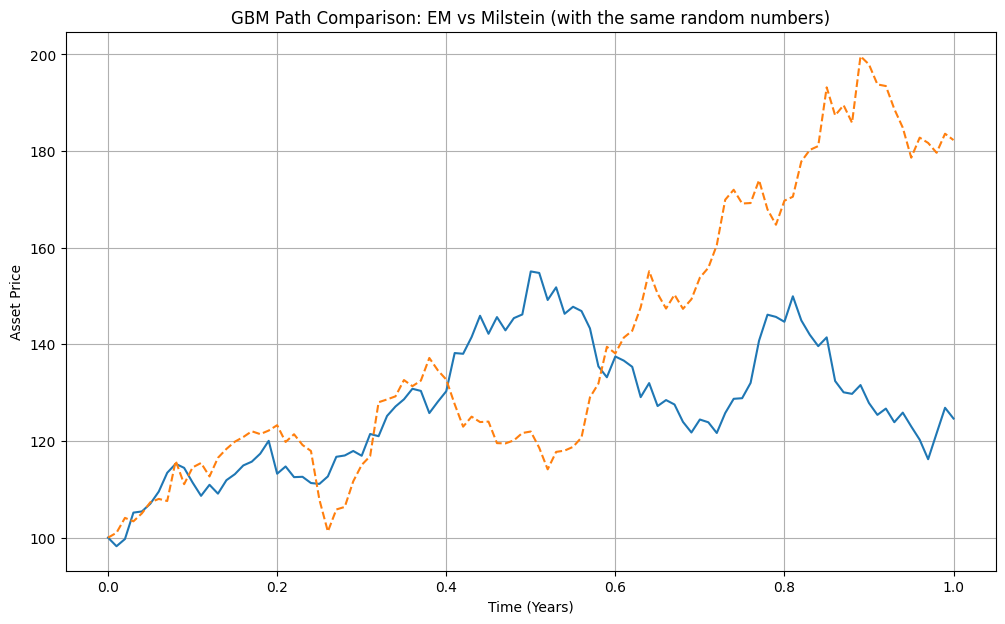

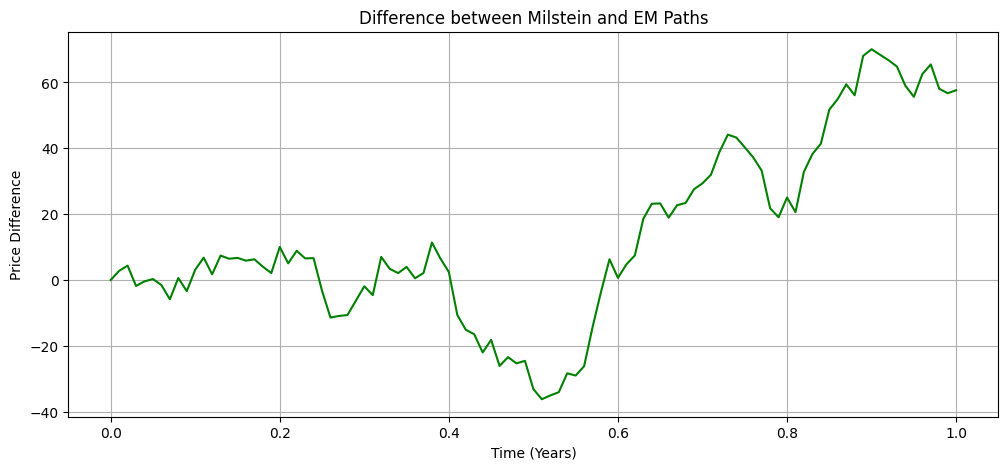

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

#importing simulation functions here (the 2 here bcs we'll compare)

from sde_simulator.simulators import simulate_gbm_em_vectorized, simulate_gbm_milstein_vectorized

S0 = 100      #initial stock price
MU = 0.05     #drift (5% annual return)
SIGMA = 0.3   #volatility (30% annual volatility)
T = 1         #time horizon (1 year)
DT = 0.01     #time step (lower on this notebook to see the difference better)
PATHS = 1     #number of paths (times we repeat the function we did on day 1 basically)


#random numbers (one set only)
N_STEPS = int(T / DT)
Z_shared = np.random.normal(0, 1, size=(N_STEPS, PATHS))

#here, the 2 simulations will have a shared random number (Z)
print("Euler-Maruyama simulation :") ; t_em, S_em = simulate_gbm_em_vectorized(S0, MU, SIGMA, T, DT, PATHS, Z = Z_shared)
print("Milstein simulation :")       ; t_milstein, S_milstein = simulate_gbm_milstein_vectorized(S0, MU, SIGMA, T, DT, PATHS, Z = Z_shared)

# --- Plotting the comparison ---
plt.figure(figsize=(12, 7))

# Plotting the single path from each simulation
plt.plot(t_em, S_em[:, 0], label=f'Euler-Maruyama (EM) (dt={DT})', lw=1.5)
plt.plot(t_milstein, S_milstein[:, 0], label=f'Milstein (dt={DT})', lw=1.5, linestyle='--')

plt.title(f'GBM Path Comparison: EM vs Milstein (with the same random numbers)')
plt.xlabel('Time (Years)')
plt.ylabel('Asset Price')
plt.grid(True)
plt.show()

#difference plot here
plt.figure(figsize=(12, 5))
plt.plot(t_em, S_milstein[:, 0] - S_em[:, 0], color='green')
plt.title('Difference between Milstein and EM Paths')
plt.xlabel('Time (Years)')
plt.ylabel('Price Difference')
plt.grid(True)
plt.show()